In [1]:
import os
import sys
sys.path.insert(0, '..')
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import gym
import load_policy

%matplotlib inline

In [2]:
task = 'Walker2d-v1'
hidden_layer_num = 2
hidden_layer_size = 30
training_data_pkl = '../train_test_data/Walker2d-10-rollouts-200.pkl'
# model_prefix = 'dagger-models/trained-with-dagger-5-by-1000-epochs/a'
# model_prefix = 'dagger-models/trained-with-dagger-10-by-1000-epochs/a'
# model_prefix = 'dagger-models/trained-with-dagger-20-by-1000-epochs/a'
model_prefix = 'dagger-models/trained-with-dagger-30-by-1000-epochs/a'

# Compare mse change from no-DAgger training

In [3]:
# no_dagger_csv = './dagger-models/train-with-no-dagger-5000-epochs/mse_train_test.csv'
# no_dagger_csv = './dagger-models/train-with-no-dagger-10000-epochs/mse_train_test.csv'
# no_dagger_csv = './dagger-models/train-with-no-dagger-20000-epochs/mse_train_test.csv'
no_dagger_csv = './dagger-models/train-with-no-dagger-30000-epochs/mse_train_test.csv'
dagger_csv = os.path.join(os.path.dirname(model_prefix), 'mse_train_test.csv')
df_no_da = pd.read_csv(no_dagger_csv)
df_da = pd.read_csv(dagger_csv)

(0, 0.1)

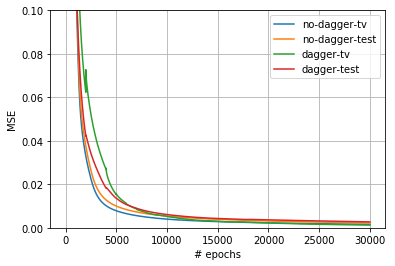

In [4]:
ax = plt.axes()

plt.plot(df_no_da.tv_mse, label='no-dagger-tv')
plt.plot(df_no_da.test_mse, label='no-dagger-test')
plt.plot(df_da.tv_mse, label='dagger-tv')
plt.plot(df_da.test_mse, label='dagger-test')
plt.legend()
plt.xlabel('# epochs')
plt.ylabel('MSE')
plt.grid()
plt.ylim(0, 0.10)

In [5]:
# TODO: this should be refactored and DRY from tuning-hyperparameters-and-visualization/train_humanoid.py

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


with open(training_data_pkl, 'rb') as inf:
    X_tv, y_tv, X_test, y_test = pickle.load(inf)

tf.logging.info('{0}, {1}, {2}, {3}'.format(
    X_tv.shape, X_test.shape, y_tv.shape, y_test.shape
))

x_plh = tf.placeholder(tf.float32, shape=[None, X_tv.shape[1]])
y_plh = tf.placeholder(tf.float32, shape=[None, y_tv.shape[1]])

with tf.name_scope('fc1'):
    Wh_var = weight_variable([x_plh.shape.dims[1].value, hidden_layer_size])
    bh_var = bias_variable([hidden_layer_size])
    hh = tf.nn.sigmoid(tf.matmul(x_plh, Wh_var) + bh_var)

for i in range(hidden_layer_num - 1):
    with tf.name_scope('fc{0}'.format(i + 2)):
        Wh_var = weight_variable([hidden_layer_size, hidden_layer_size])
        bh_var = bias_variable([hidden_layer_size])
        hh = tf.nn.sigmoid(tf.matmul(hh, Wh_var) + bh_var)

with tf.name_scope('out'):
    W_var = weight_variable([hidden_layer_size, y_plh.shape.dims[1].value])
    b_var = bias_variable([y_plh.shape.dims[1].value])
    y_pred = tf.matmul(hh, W_var) + b_var

INFO:tensorflow:(1608, 17), (402, 17), (1608, 6), (402, 6)


In [6]:
with tf.name_scope('mse'):
    mse = tf.losses.mean_squared_error(labels=y_plh, predictions=y_pred)
    mse = tf.cast(mse, tf.float32)

with tf.name_scope('adam_optimizer'):
    train_op = tf.train.AdamOptimizer(1e-4).minimize(mse)

In [7]:
saver = tf.train.Saver()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [8]:
saver.restore(sess, model_prefix)

INFO:tensorflow:Restoring parameters from dagger-models/trained-with-dagger-30-by-1000-epochs/a


# Evaluate performance

In [9]:
def pred_action(obs):
    return y_pred.eval(feed_dict={x_plh: obs.reshape(1, -1)})

In [10]:
env = gym.make(task)

done = False
max_timesteps = 1000
num_rollouts = 100
rewards = []
for _ in range(num_rollouts):
    totalr = 0
    obs = env.reset()
    for k in range(max_timesteps):
        if (k + 1) % 100 == 0:
            print(k + 1, end=',')
        action = pred_action(obs)
        obs, r, done, _ = env.step(action)
        totalr += r
#         env.render()
#     env.render(close=True)
    rewards.append(totalr)
    print()
print()
print(np.mean(rewards))
print(np.std(rewards))

100,200,300,400,500,600,700,800,900,1000,
100,200,300,400,500,600,700,800,900,1000,
100,200,300,400,500,600,700,800,900,1000,
100,200,300,400,500,600,700,800,900,1000,
100,200,300,400,500,600,700,800,900,1000,
100,200,300,400,500,600,700,800,900,1000,
100,200,300,400,500,600,700,800,900,1000,
100,200,300,400,500,600,700,800,900,1000,
100,200,300,400,500,600,700,800,900,1000,
100,200,300,400,500,600,700,800,900,1000,
100,200,300,400,500,600,700,800,900,1000,
100,200,300,400,500,600,700,800,900,1000,
100,200,300,400,500,600,700,800,900,1000,
100,200,300,400,500,600,700,800,900,1000,
100,200,300,400,500,600,700,800,900,1000,
100,200,300,400,500,600,700,800,900,1000,
100,200,300,400,500,600,700,800,900,1000,
100,200,300,400,500,600,700,800,900,1000,
100,200,300,400,500,600,700,800,900,1000,
100,200,300,400,500,600,700,800,900,1000,
100,200,300,400,500,600,700,800,900,1000,
100,200,300,400,500,600,700,800,900,1000,
100,200,300,400,500,600,700,800,900,1000,
100,200,300,400,500,600,700,800,90

#### Expert performance

Expert's return at 1000 timestep is from 10 rollouts

mean return 5561.63878827
std of return 32.2141290284

Collected by running 

```
python run_expert.py experts/Walker2d-v1.pkl Walker2d-v1 --max_timesteps 1000 --num_rollouts 10
```

# Visualize performance

In [11]:
env = gym.make(task)

obs = env.reset()

totalr = 0
done = False
max_timesteps = 1000
for k in range(max_timesteps):
    if (k + 1) % 20 == 0:
        print(k + 1, end=',')
    action = pred_action(obs)
    obs, r, done, _ = env.step(action)
    totalr += r
    env.render()
env.render(close=True)
print()
print(totalr)
print(np.mean(totalr))

20,40,60,80,100,120,140,160,180,200,220,240,260,280,300,320,340,360,380,400,420,440,460,480,500,520,540,560,580,600,620,640,660,680,700,720,740,760,780,800,820,840,860,880,900,920,940,960,980,1000,
2798.71078021
2798.71078021
